# Построение ML продукта для предсказания визитов клиентов
Описание: [mle_предсказание_количества_визитов](https://incredible-tulip-5c3.notion.site/Machine-learning-engineer-2024-e4c30223002a4eebb33d2cdeb8f81fb1)

**Формулировка задачи:**

Доступны данные о количестве обращений за медицинской помощью по 50 000 застрахованным ДМС за 2022 год.
<br>Требуется на основании характеристик застрахованных и истории их обращений за 2022 год предсказать количество визитов за 2023 год. 

Доступны 2 выборки: 

- train - выборка для обучения и валидации , 50 тыс. застрахованных с проставленными значениями target.
- holdout - выборка для финального замера качества модели. В этой выборке 10 000 застрахованных, истинные значения target скрыты.

Для оценки качества модели будет применяться метрика `MSE`.

**Описание данных:**

- Insured_PIN - уникальный ид застрахованного лица
- Insured_Network - Идентификатор сети клиник доступной для застрахованного. Network - 1 - клиники с наивысшим уровнем сервиса, Network - 8 - клиники с самым базовым уровнем сервиса.
- Nationality - национальность застрахованного.
- Gender - пол застрахованного
- Relation - в качестве кого застраховано данное лицо. self - работник организации, которая оформляет страховку, child - ребенок застрахованного и т.д.
- DoB - дата рождения застрахованного
- Diagnoses - все диагнозы застрахованного за 2022 год
- HasChronicDisease - флаг хронического пациента
- Exposition_22 - количество дней в 2022 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2022 год
- number_of_visits_22 - количество дней в 2022 году в которые застрахованный посещал клинику для получения медицинской помощи
- number_of_services_22 - количество оказанных медицинских услуг в 2022 году (консультации, анализы, лекарства и т.д.)
- Exposition_23 - количество дней в 2023 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2023 год
- **Target -** number_of_visits_23 - количество дней в 2023 году в которые застрахованный посещал клинику для получения медицинской помощи. **Этот показатель требуется предсказать.**

**Ход исследования**

- загрузка данных и ознакомление с ними;
- первичная обработка данных;
- исследовательский анализ данных;
- создание новых признаков (при необходимости);
- отбор финального набора обучающих признаков;
- подготовка данных для обучения;
- выбор и обучение моделей;
- оценка качества предсказания лучшей модели на тестовой выборке;
- анализ важности признаков лучшей модели;
- прогноз для отложенных данных;
- отчёт по проведённому исследованию.

## Настройка рабочей среды

In [1]:
# !pip install pandas
# !pip install openpyxl
# !pip install seaborn
# !pip install phik
# !pip install scikit-learn
# !pip install mlflow
# !pip install psycopg2-binary
# !pip install python-dotenv
# !pip install autofeat
# !pip install shap
# !pip install catboost

In [2]:
import os
import shap
import phik
import mlflow
import psycopg2
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from autofeat import AutoFeatRegressor
from sklearn.compose import ColumnTransformer
from phik.report import plot_correlation_matrix
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV

Установка констант

In [3]:
RANDOM_STATE = 42
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
EXPERIMENT_NAME = 'mains_lab'
RUN_NAME = ['baseline_0_registry', 'linreg_4_registry', 'random_forest_0_registry', 'catboost_0_registry']
REGISTRY_MODEL_NAME = ['baseline', 'linear_regression', 'random_forest', 'catboost']
load_dotenv()
connection = {"sslmode": "require",
              "target_session_attrs": "read-write"}
postgres_credentials = {"host": os.getenv("DB_HOST"),
                        "port": os.getenv("DB_PORT"),
                        "dbname": os.getenv("DB_NAME"),
                        "user": os.getenv("DB_USERNAME"),
                        "password": os.getenv("DB_PASSWORD")}
pd.options.display.max_rows = 50
pd.options.display.max_columns = 50
sns.set_style('white')
sns.set_theme(style='whitegrid')
train_data_path = 'data/ML_train.xlsx'
holdout_data_path = 'data/ML_holdout.xlsx'

## Загрузка данных

In [4]:
data = pd.read_excel(train_data_path)
holdout_data = pd.read_excel(holdout_data_path)

In [5]:
def data_review(dataset):
    '''
    на вход принимает датафрейм,
    выводит общую обзорную информацию
    '''
    print('Общая информация о наборе данных:')
    dataset.info()
    print()
    print('Первые пять строк набора данных:')
    display(dataset.head())
    print()
    print(f"количество полных дубликатов строк: {dataset.duplicated().sum()}")
    print()
    print('Вывод количества уникальных записей в каждом текстовом признаке:')
    for column in dataset.select_dtypes(include=['object']).columns:
        unique_values = dataset[column].nunique()
        print(f"Количество уникальных записей в признаке '{column}': {unique_values}")
    print()
    print('Вывод количества уникальных записей в каждом числовом признаке:')
    for column in dataset.select_dtypes(include=['int']).columns:
        unique_values = dataset[column].nunique()
        print(f"Количество уникальных записей в признаке '{column}': {unique_values}")
    print()
    for column in dataset.select_dtypes(include=['datetime']).columns:
        print(f"Самая ранняя дата в признаке '{column}': {min(dataset['DoB'])}")
        print(f"Самая поздняя дата в признаке '{column}': {max(dataset['DoB'])}")

In [6]:
data_review(data)

Общая информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_PIN            50000 non-null  int64         
 1   Insured_Network        50000 non-null  object        
 2   Nationality            50000 non-null  object        
 3   Gender                 50000 non-null  object        
 4   Relation               50000 non-null  object        
 5   DoB                    49999 non-null  datetime64[ns]
 6   Diagnoses              41226 non-null  object        
 7   HasChronicDisease      50000 non-null  int64         
 8   Exposition_22          50000 non-null  int64         
 9   number_of_visits_22    50000 non-null  int64         
 10  number_of_services_22  50000 non-null  int64         
 11  Exposition_23          50000 non-null  int64         
 12  number_of_visits_23    500

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23
0,1006786,Network-4,Group 2,Male,Self,1974-04-28,NaN,0,365,0,0,365,0
1,1008861,Network-2,Saudi,Female,Child,2017-07-27,J20.9;J02,0,365,1,2,365,4
2,1019055,Network-5,Group 2,Male,Self,1979-02-20,J03.9,0,365,1,4,365,5
3,1019438,Network-1,Saudi,Male,Self,1985-05-09,E56.9;J02;J00,1,365,3,18,365,11
4,1027311,Network-3,Group 3,Male,Self,1962-01-01,NaN,0,365,0,0,365,0



количество полных дубликатов строк: 0

Вывод количества уникальных записей в каждом текстовом признаке:
Количество уникальных записей в признаке 'Insured_Network': 8
Количество уникальных записей в признаке 'Nationality': 6
Количество уникальных записей в признаке 'Gender': 2
Количество уникальных записей в признаке 'Relation': 5
Количество уникальных записей в признаке 'Diagnoses': 35466

Вывод количества уникальных записей в каждом числовом признаке:
Количество уникальных записей в признаке 'Insured_PIN': 50000
Количество уникальных записей в признаке 'HasChronicDisease': 2
Количество уникальных записей в признаке 'Exposition_22': 307
Количество уникальных записей в признаке 'number_of_visits_22': 79
Количество уникальных записей в признаке 'number_of_services_22': 272
Количество уникальных записей в признаке 'Exposition_23': 258
Количество уникальных записей в признаке 'number_of_visits_23': 89

Самая ранняя дата в признаке 'DoB': 1920-03-21 00:00:00
Самая поздняя дата в признаке '

In [7]:
data_review(holdout_data)

Общая информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_PIN            10000 non-null  int64         
 1   Insured_Network        10000 non-null  object        
 2   Nationality            10000 non-null  object        
 3   Gender                 10000 non-null  object        
 4   Relation               10000 non-null  object        
 5   DoB                    10000 non-null  datetime64[ns]
 6   Diagnoses              8274 non-null   object        
 7   HasChronicDisease      10000 non-null  int64         
 8   Exposition_22          10000 non-null  int64         
 9   number_of_visits_22    10000 non-null  int64         
 10  number_of_services_22  10000 non-null  int64         
 11  Exposition_23          10000 non-null  int64         
dtypes: datetime64[ns](1), int64

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23
0,1516424,Network-2,Saudi,Female,Child,2012-09-06,A09,0,365,1,3,365
1,22210474,Network-1,Saudi,Female,Child,1995-10-26,T78.4;R50.9;Z01.8;R05,0,365,4,22,365
2,1518945,Network-2,Saudi,Female,Spouse,1962-11-28,D64.9;J06;H04.1;M13.9,0,365,5,11,365
3,1344077,Network-2,Saudi,Male,Child,2003-07-09,J06.9;J06.8;J02;G44.0;M25.5;R51;E55;L03,1,365,9,30,365
4,1354276,Network-2,Saudi,Female,Spouse,1995-07-22,UNKRC;N64;A09,0,365,3,10,365



количество полных дубликатов строк: 0

Вывод количества уникальных записей в каждом текстовом признаке:
Количество уникальных записей в признаке 'Insured_Network': 8
Количество уникальных записей в признаке 'Nationality': 6
Количество уникальных записей в признаке 'Gender': 2
Количество уникальных записей в признаке 'Relation': 5
Количество уникальных записей в признаке 'Diagnoses': 7434

Вывод количества уникальных записей в каждом числовом признаке:
Количество уникальных записей в признаке 'Insured_PIN': 10000
Количество уникальных записей в признаке 'HasChronicDisease': 2
Количество уникальных записей в признаке 'Exposition_22': 189
Количество уникальных записей в признаке 'number_of_visits_22': 64
Количество уникальных записей в признаке 'number_of_services_22': 212
Количество уникальных записей в признаке 'Exposition_23': 154

Самая ранняя дата в признаке 'DoB': 1922-02-13 00:00:00
Самая поздняя дата в признаке 'DoB': 2022-11-12 00:00:00


In [7]:
print('информация о застрахованном, у которого пропущена дата рождения:')
data[data['DoB'].isna()]

информация о застрахованном, у которого пропущена дата рождения:


,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23
23626,1451433,Network-2,Saudi,Male,Self,NaT,H93.1;A09.9;R10;N39.0;M79;E78.5;N77.1;M23;E11....,1,365,15,62,365,14


### Выводы и наблюдения
- в двух признаках имеются пропущенные значения: `DoB` и `Diagnoses`:
  - `DoB` - можно заполнить обработать, но клиент может оказаться нетипичным -
    <br>у него большое количество диагнозов;
  - `Diagnoses` - у клиентов может не быть поставленных диагнозов -
    <br>пропуски нужно обработать;
- дубликатов строк в наборе данных не обнаружено;
- в данных пять категориальных признаков,
  <br>четыре из них текстовые - потребуется кодирование;
- все значения `Insured_PIN` уникальны;
- дату рождения необходимо модифицировать в возраст;
- разброс дат рождения от `1920-03-21` до `2022-11-12`

## Предобработка данных

Добавление признака `number_of_diagnoses` с количеством диагнозов клиента

In [8]:
data['number_of_diagnoses'] = data['Diagnoses'].apply(lambda x: 0 if pd.isnull(x) else len(x.split(';')))

Добавление признаков `client_age_22` и `client_age_23` с возрастом клиента на конец 2022 и 2023 года соответственно.

In [9]:
def client_age_counting(dataset, birth_date, fixed_dates, new_column_names):
    '''
    - на вход принимает датафрейм, дату рождения, даты, на которые нужно посчитать возраст, названия новых признаков
    - возвращает датафрейм с добавленными признаками
    '''
    
    for fixed_date, new_column_name in zip(fixed_dates, new_column_names):
        fixed_date = pd.to_datetime(fixed_date)
        dataset[new_column_name] = (fixed_date - dataset[birth_date]).dt.days // 365
    
    return dataset

In [10]:
data = client_age_counting(dataset=data,
                           birth_date='DoB',
                           fixed_dates=['2022-12-31', '2023-12-31'],
                           new_column_names=['client_age_22', 'client_age_23'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_PIN            50000 non-null  int64         
 1   Insured_Network        50000 non-null  object        
 2   Nationality            50000 non-null  object        
 3   Gender                 50000 non-null  object        
 4   Relation               50000 non-null  object        
 5   DoB                    49999 non-null  datetime64[ns]
 6   Diagnoses              41226 non-null  object        
 7   HasChronicDisease      50000 non-null  int64         
 8   Exposition_22          50000 non-null  int64         
 9   number_of_visits_22    50000 non-null  int64         
 10  number_of_services_22  50000 non-null  int64         
 11  Exposition_23          50000 non-null  int64         
 12  number_of_visits_23    50000 non-null  int64         
 13  n

### Выводы и наблюдения
- добавлен признак, в котором посчитано количество диагнозов у клиента;
- добавлены признаки с возрастом клиента на конец 2022 и 2023 годов

## Исследовательский анализ данных

Деление данных по типам

In [11]:
ids = ['Insured_PIN']
target = ['number_of_visits_23']
cat_features = data.select_dtypes(include=['object']).drop('Diagnoses', axis=1).columns.to_list()
potential_num_features = data.select_dtypes(include=['number']).columns
binary_num_features = [col for col in potential_num_features if data[col].nunique() == 2]
num_features = list(set(potential_num_features) - set(binary_num_features) - set(ids) - set(target))

Количество клиентов, разделённых по различным группам

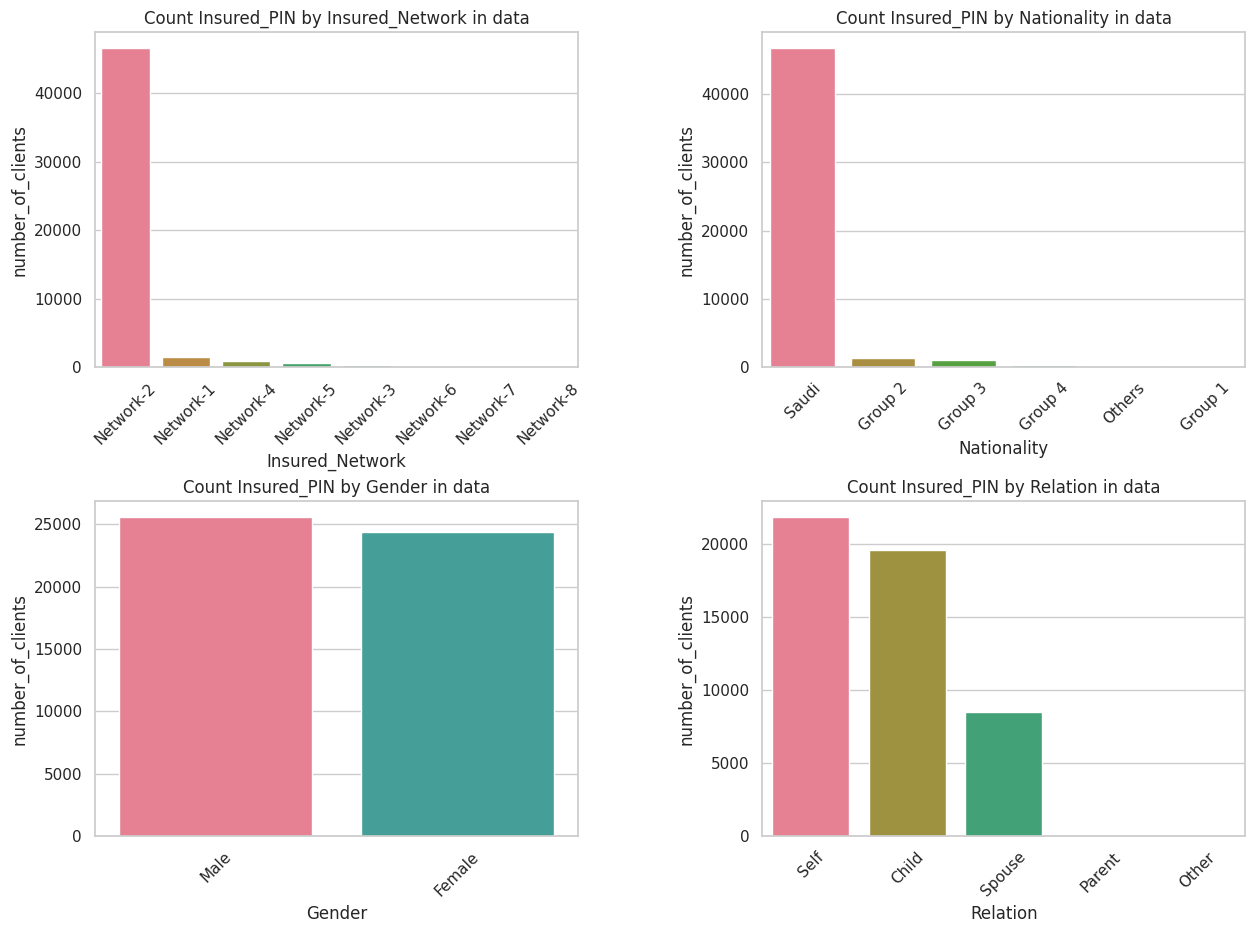

In [12]:
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.8)
fig.set_size_inches(14, 10, forward=True)

for i, col in enumerate(cat_features):
    agg_df = data.groupby(col).agg({'Insured_PIN': 'count'}).reset_index()
    agg_df = agg_df.sort_values(by='Insured_PIN', ascending=False)
    sns.barplot(x=col,
                y='Insured_PIN',
                data=agg_df,
                ax=axs[i // 2, i % 2],
                hue=col,
                palette=sns.color_palette("husl", len(agg_df)),
                legend=False)
    axs[i // 2, i % 2].set_title(f'Count Insured_PIN by {col} in data')
    axs[i // 2, i % 2].set_xticks(range(len(agg_df)))
    axs[i // 2, i % 2].set_xticklabels(agg_df[col], rotation=45)
    axs[i // 2, i % 2].set_ylabel('number_of_clients')
plt.show()

Соотношение классов бинарных числовых признаков

2024-04-06 18:25:26,740 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-06 18:25:26,747 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


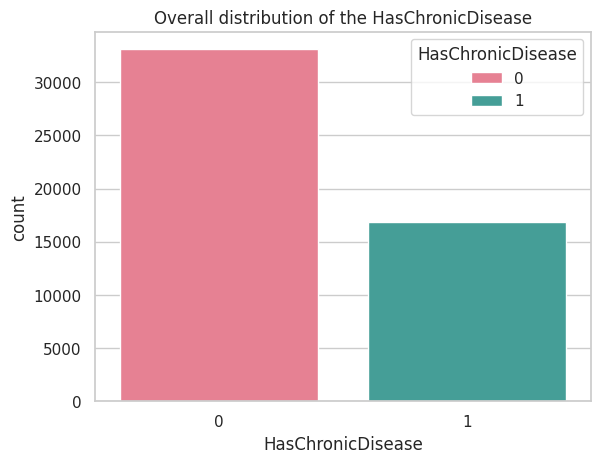

In [13]:
sns.barplot(data=data[binary_num_features[0]].value_counts().reset_index(),
            x=binary_num_features[0],
            y='count',
            hue=binary_num_features[0],
            palette=sns.color_palette("husl", len(data[binary_num_features[0]].value_counts().reset_index())))
plt.title(f"Overall distribution of the {binary_num_features[0]}")
plt.show()

Вывод описательных статистик по небинарным числовым данным

In [14]:
data[num_features+target].describe()

,number_of_services_22,Exposition_22,Exposition_23,number_of_visits_22,client_age_23,client_age_22,number_of_diagnoses,number_of_visits_23
count,50000.000000,50000.000000,50000.000000,50000.000000,49999.000000,49999.000000,50000.000000,50000.000000
mean,22.477420,358.898960,355.588420,5.740320,33.395888,32.395888,5.667140,5.898860
std,29.714146,35.562003,43.779065,6.592556,22.760938,22.760938,6.265359,6.856904
min,0.000000,50.000000,50.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,365.000000,365.000000,1.000000,12.000000,11.000000,1.000000,1.000000
50%,13.000000,365.000000,365.000000,4.000000,32.000000,31.000000,4.000000,4.000000
75%,31.000000,365.000000,365.000000,8.000000,52.000000,51.000000,8.000000,8.000000
max,962.000000,365.000000,365.000000,151.000000,103.000000,102.000000,266.000000,202.000000


/tmp/ipykernel_44313/3902728846.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(labels=axs[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_44313/3902728846.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(labels=axs[1].get_xticklabels(), rotation=45)


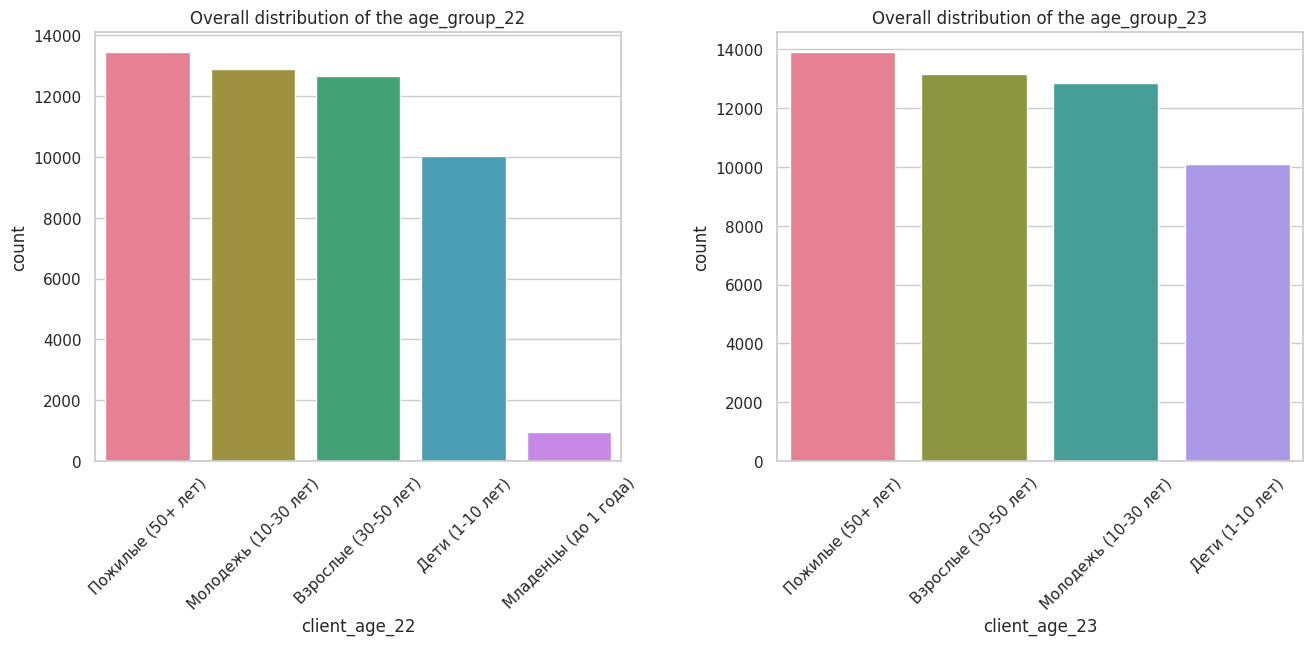

In [15]:
def categorize_age(age):
    if age < 1:
        return 1
    elif age < 10:
        return 2
    elif age < 30:
        return 3
    elif age < 50:
        return 4
    else:
        return 5

age_groups_labels = {
    1: 'Младенцы (до 1 года)',
    2: 'Дети (1-10 лет)',
    3: 'Молодежь (10-30 лет)',
    4: 'Взрослые (30-50 лет)',
    5: 'Пожилые (50+ лет)'
}

fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=1.0)
fig.set_size_inches(14, 5, forward=True)

sns.barplot(data=data['client_age_22'].apply(categorize_age).map(age_groups_labels).value_counts().reset_index(),
            x='client_age_22',
            y='count',
            hue='client_age_22',
            ax=axs[0],
            palette=sns.color_palette("husl", len(data['client_age_22'].apply(categorize_age).value_counts().reset_index())))
axs[0].set_title(f"Overall distribution of the age_group_22")
axs[0].set_xticklabels(labels=axs[0].get_xticklabels(), rotation=45)

sns.barplot(data=data['client_age_23'].apply(categorize_age).map(age_groups_labels).value_counts().reset_index(),
            x='client_age_23',
            y='count',
            hue='client_age_23',
            ax=axs[1],
            palette=sns.color_palette("husl", len(data['client_age_23'].apply(categorize_age).value_counts().reset_index())))
axs[1].set_title(f"Overall distribution of the age_group_23")
axs[1].set_xticklabels(labels=axs[1].get_xticklabels(), rotation=45)

plt.show()

Распределение целевой переменной в различных группах клиентов

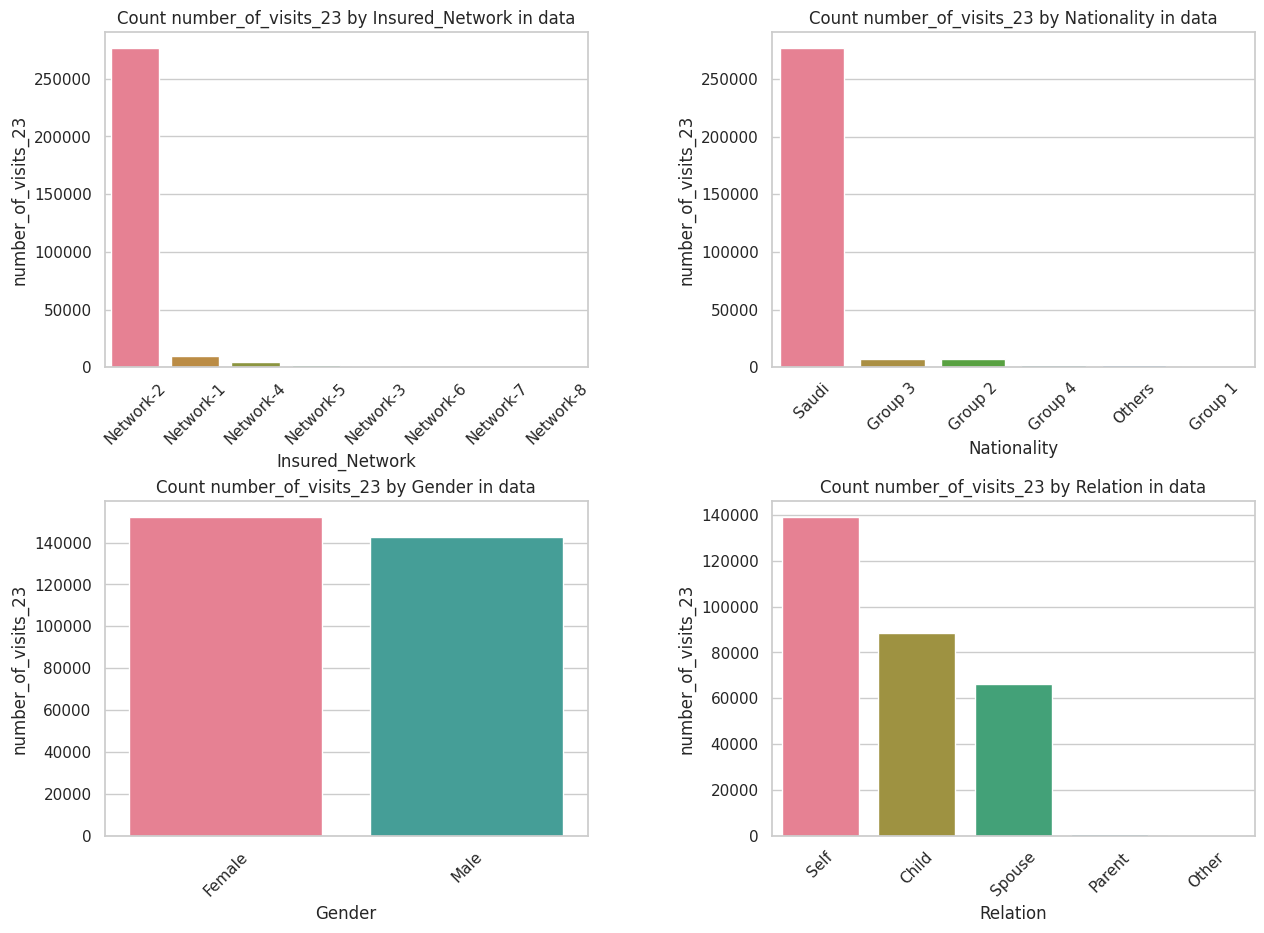

In [16]:
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.8)
fig.set_size_inches(14, 10, forward=True)

for i, col in enumerate(cat_features):
    agg_df = data.groupby(col).agg({target[0]: 'sum'}).reset_index()
    agg_df = agg_df.sort_values(by=target[0], ascending=False)
    sns.barplot(x=col,
                y=target[0],
                data=agg_df,
                ax=axs[i // 2, i % 2],
                hue=col,
                palette=sns.color_palette("husl", len(agg_df)),
                legend=False)
    axs[i // 2, i % 2].set_title(f'Count number_of_visits_23 by {col} in data')
    axs[i // 2, i % 2].set_xticks(range(len(agg_df)))
    axs[i // 2, i % 2].set_xticklabels(agg_df[col], rotation=45)
    axs[i // 2, i % 2].set_ylabel(target[0])
plt.show()

Выявление скрытых зависимостей между признаками

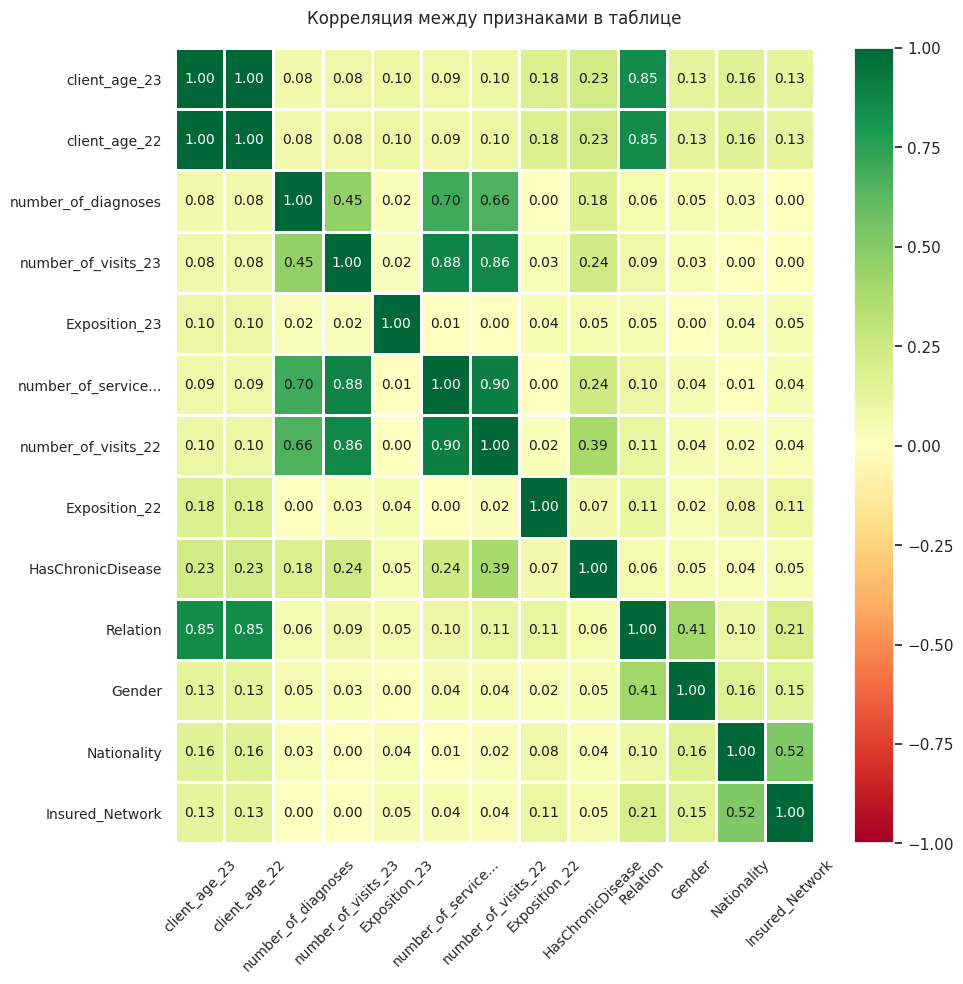

In [17]:
phik_overview = data.drop(columns=['Insured_PIN', 'DoB', 'Diagnoses']).phik_matrix(interval_cols=num_features+target)
sns.set()
plot_correlation_matrix(phik_overview.values,
						x_labels=phik_overview.columns,
						y_labels=phik_overview.index,
						fontsize_factor=1.0,
						figsize=(10, 10))
plt.xticks(rotation=45)
plt.title(f'Корреляция между признаками в таблице', fontsize=12, y=1.02)
plt.tight_layout()

### Выводы и наблюдения
- исследование по клиентам:
  - основная сеть клиник, доступная клиентам - `Network-2`;
  - большинство клиентов, представлены национальностью `Saudi`;
  - мужчин и женщин в выборке примерно одинаковое количество;
  - основные роли клиентов: застрахован лично, застраховал ребёнка, застраховал супруга(у);
- наблюдается большой дисбаланс классов в признаке `HasChronicDisease`;
- исследование числовых признаков:
  - средний возраст клиентов примерно соответствует медианному, пропуск можно заполнить одним из них;
  - можно отследить пять возрастных групп клиентов;
  - среднее количество дней действия полиса по годам примерно соответствует медианному,
    <br>что свидетельствует о близком к нормальному распределению;
  - распределение по возрастным группам практически равномерное, за исключением группы младенцев,
    <br>но их можно отнести к группе "Дети (0-10 лет)";
  - большинство пользователей совершают относительно небольшое количество посещений (до 8),
    <br>но также есть пользователи, которые совершают значительно больше посещений (151 - 202),
    <br>что требует дополнительного изучения,
    <br>похожая ситуация с признаками `number_of_services_22` и	`number_of_diagnoses`;
- исследование по целевому признаку:
  - основная сеть клиник, доступная клиентам - `Network-2`;
  - большинство клиентов, представлены национальностью `Saudi`;
  - женщины посещают клиники больше мужчин;
  - основные роли клиентов по количеству посущений: застрахован лично, застраховал ребёнка, застраховал супруга(у);
- исследование корреляции Фай-Фи в данных:
  - между некоторыми признаками наблюдаются значительные зависимости:
    - relation и client_age;
    - number_of_visits_23, number_of_visits_22, number_of_services_22.

## Генерация дополнительных признаков

Заполнение пропусков

In [12]:
data.fillna({'client_age_23': data['client_age_23'].median(),
             'client_age_22': data['client_age_22'].median()}, inplace=True)
data['client_age_23'] = data['client_age_23'].astype(int)
data['client_age_22'] = data['client_age_22'].astype(int)

Функции для создания признаков

In [13]:
def categorize_age(age):
    if age < 10:
        return 1
    elif age < 30:
        return 2
    elif age < 50:
        return 3
    else:
        return 4

In [14]:
def feature_engineering(input_data,
                        num_features,
                        target,
                        test_size,
                        input_columns,
                        output_columns,
                        transformations,
                        data_train=None,
                        data_holdout=None):
    X_ext_cat = input_data[num_features].copy()
    for input_col, output_col in zip(input_columns, output_columns):
        X_ext_cat[output_col] = X_ext_cat[input_col].apply(categorize_age)

    if test_size:
        X_train, X_test, y_train, y_test = train_test_split(data.drop(target, axis=1),
                                                            data[target],
                                                            test_size=test_size,
                                                            random_state=RANDOM_STATE)
    else:
        X_train, X_test, y_train = (data_train.drop(target, axis=1),
                                    data_holdout,
                                    data_train[target])

    afreg = AutoFeatRegressor(feateng_steps=2, max_gb=4, transformations=transformations)
    X_train_afr = afreg.fit_transform(X_train[num_features], y_train)
    X_test_tr = afreg.transform(X_test[num_features])
    X_ext_num = pd.concat([X_train_afr, X_test_tr], ignore_index=True)
    new_num_features = [col for col in X_ext_num.columns if col not in num_features]
    X_ext_num = X_ext_num[new_num_features]
    X_ext_cat = X_ext_cat[output_columns]
    print("Новые категориальные признаки:")
    X_ext_cat.info()
    print("Новые числовые признаки:")
    X_ext_num.info()
    return X_ext_num, X_ext_cat

In [16]:
ext_num_data, ext_cat_data = feature_engineering(input_data=data,
                                                 num_features=num_features,
                                                 target=target,
                                                 test_size=0.2,
                                                 input_columns=['client_age_22', 'client_age_23'],
                                                 output_columns=['age_group_22', 'age_group_23'],
                                                 transformations=["log", "exp-", "sqrt"])

/home/denis/Documents/main_venv/test_mains_lab/.env_lab/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denis/Documents/main_venv/test_mains_lab/.env_lab/lib/python3.10/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


Новые категориальные признаки:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   age_group_22  50000 non-null  int64
 1   age_group_23  50000 non-null  int64
dtypes: int64(2)
memory usage: 781.4 KB
Новые числовые признаки:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   number_of_diagnoses*number_of_visits_22          50000 non-null  float64
 1   number_of_visits_22*exp(-client_age_23)          50000 non-null  float64
 2   number_of_services_22*number_of_visits_22        50000 non-null  float64
 3   sqrt(number_of_visits_22)*log(client_age_23)     50000 non-null  float64
 4   client_age_23*exp(-client_age_23)                5

In [17]:
full_df = data.merge(ext_num_data, left_index=True, right_index=True).merge(ext_cat_data, left_index=True, right_index=True)
ext_num_features = ext_num_data.columns.to_list()
ext_cat_features = ext_cat_data.columns.to_list()

### Выводы и наблюдения
- заполнены пропуски;
- создан датафрейм с дополнительными признаками;
- добавлены категориальные признаки - возрастная группа;
- при помощи библиотеки `autofeat` добавлены числовые признаки

## Отбор финального набора обучающих признаков

### main_dataset

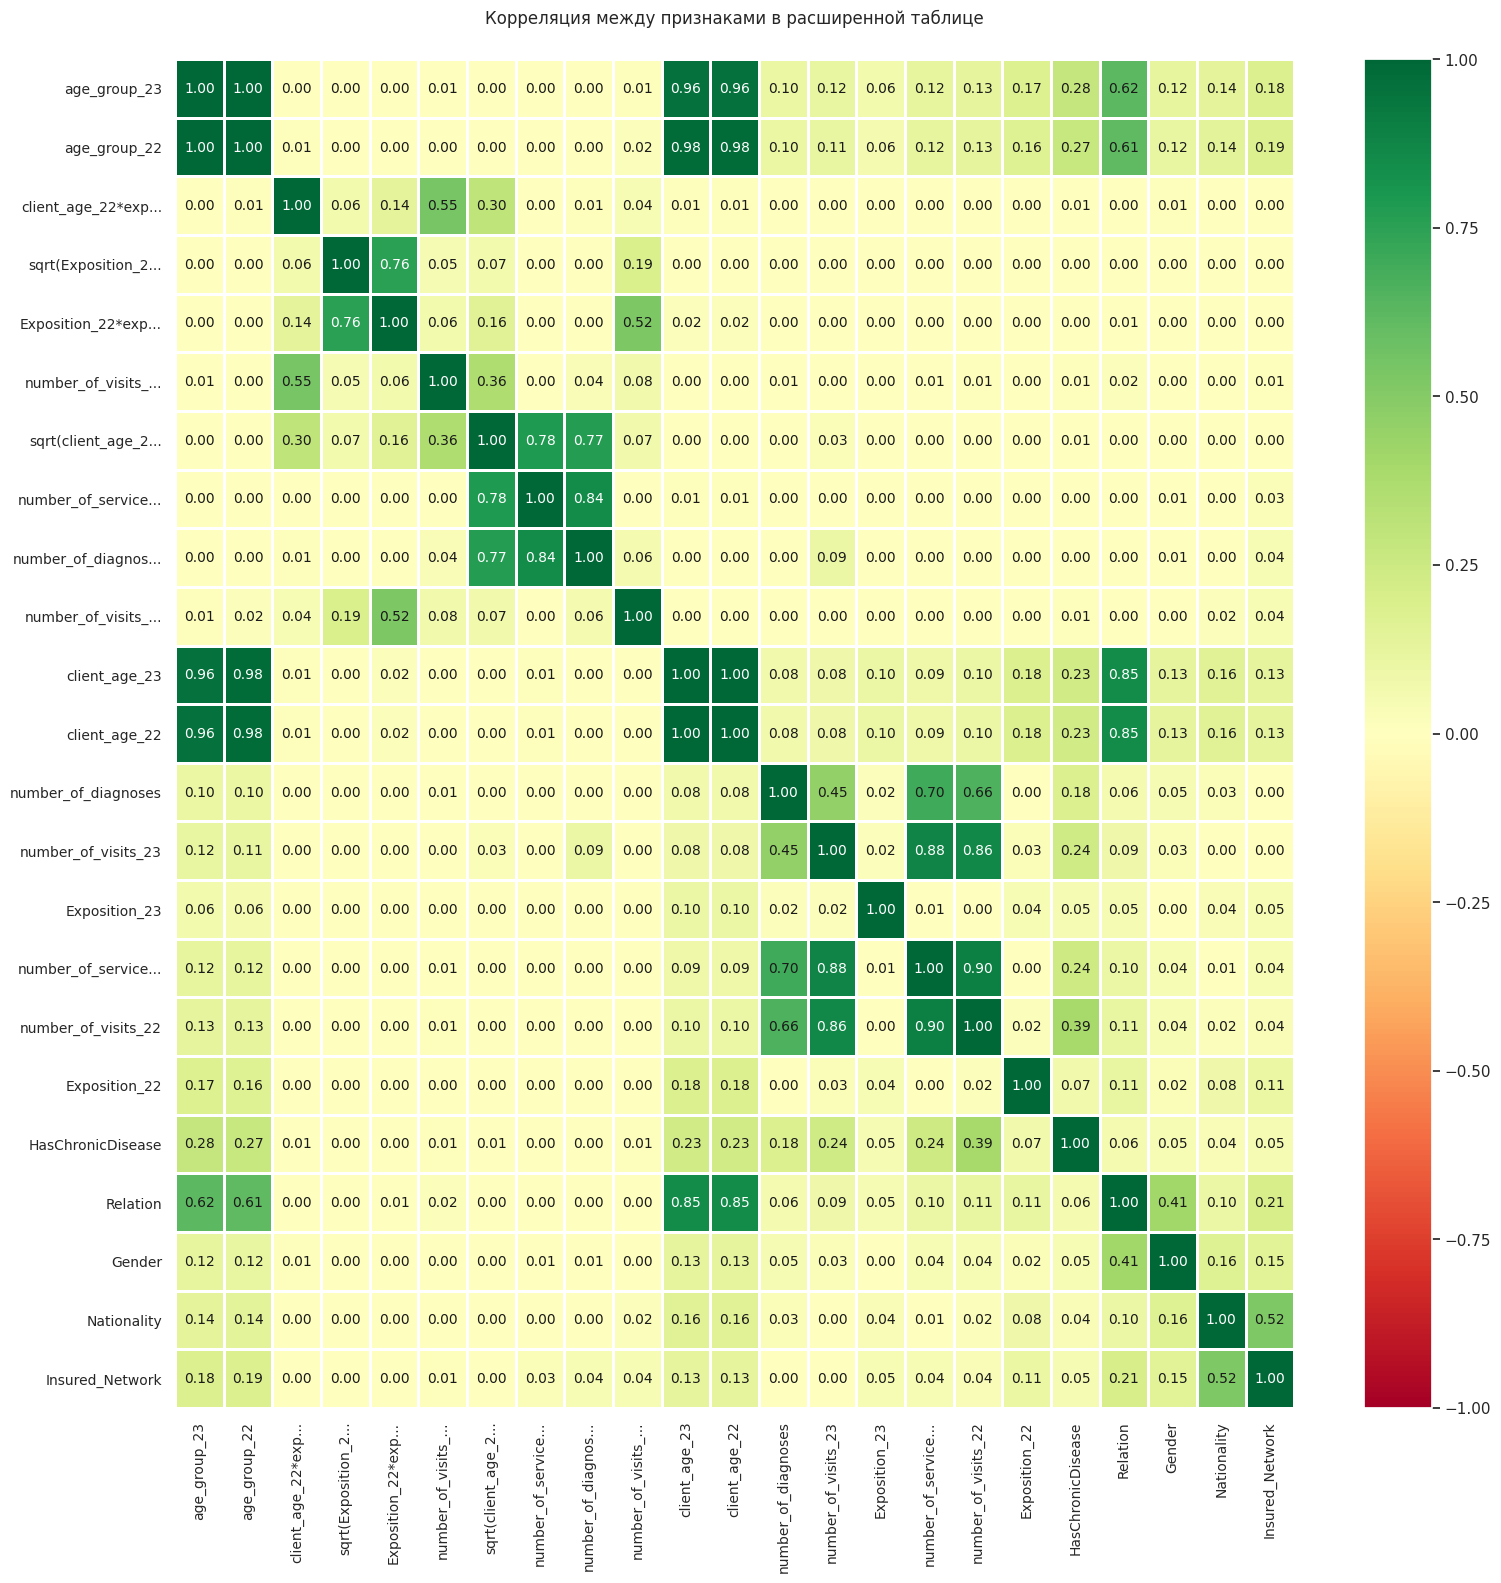

In [23]:
phik_overview = full_df.drop(columns=['Insured_PIN', 'DoB', 'Diagnoses']).phik_matrix(interval_cols=num_features+target+ext_num_data.columns.to_list())
sns.set()
plot_correlation_matrix(phik_overview.values,
						x_labels=phik_overview.columns,
						y_labels=phik_overview.index,
						fontsize_factor=1.0,
						figsize=(16, 16))
plt.xticks(rotation=90)
plt.title(f'Корреляция между признаками в расширенной таблице', fontsize=12, y=1.02)
plt.tight_layout()

Удаление признаков

In [18]:
num_features_clean = num_features.copy()
cat_features_clean = cat_features.copy()
ext_cat_features_clean = ext_cat_features.copy()
num_features_clean.remove('number_of_services_22')  # коррелирует с целевым признаком
num_features_clean.remove('number_of_visits_22')  # коррелирует с целевым признаком
num_features_clean.remove('client_age_23')  # коррелирует с признаком возрастной группы
num_features_clean.remove('client_age_22')  # коррелирует с признаком возрастной группы
ext_cat_features_clean.remove('age_group_23')  # коррелирует с признаком возрастной группы
cat_features_clean.remove('Insured_Network')  # представлен только один класс
cat_features_clean.remove('Nationality')  # представлен только один класс

Сформированные наборы признаков

In [19]:
print(f"целевой признак: {target}")
print(f"бинарные числовые признаки: {binary_num_features}")
print(f"категориальные признаки: {cat_features}")
print(f"категориальные признаки, очищенные от неинформативных: {cat_features_clean}")
print(f"числовые признаки: {num_features}")
print(f"числовые признаки, очищенные от коррелирующих: {num_features_clean}")
print(f"дополнительные числовые признаки: {ext_num_features}")
print(f"дополнительные числовые категориальные признаки: {ext_cat_features}")
print(f"дополнительные числовые категориальные признаки, очищенные от коррелирующих: {ext_cat_features_clean}")

целевой признак: ['number_of_visits_23']
бинарные числовые признаки: ['HasChronicDisease']
категориальные признаки: ['Insured_Network', 'Nationality', 'Gender', 'Relation']
категориальные признаки, очищенные от неинформативных: ['Gender', 'Relation']
числовые признаки: ['client_age_22', 'number_of_diagnoses', 'number_of_services_22', 'number_of_visits_22', 'Exposition_23', 'client_age_23', 'Exposition_22']
числовые признаки, очищенные от коррелирующих: ['number_of_diagnoses', 'Exposition_23', 'Exposition_22']
дополнительные числовые признаки: ['number_of_diagnoses*number_of_visits_22', 'number_of_visits_22*exp(-client_age_23)', 'number_of_services_22*number_of_visits_22', 'sqrt(number_of_visits_22)*log(client_age_23)', 'client_age_23*exp(-client_age_23)', 'sqrt(client_age_22)*exp(-client_age_22)', 'number_of_visits_22*exp(-number_of_visits_22)', 'number_of_diagnoses**(3/2)', 'sqrt(Exposition_22)*log(Exposition_23)', 'sqrt(client_age_22)*exp(-number_of_visits_22)', 'exp(-number_of_servi

### Выводы и наблюдения
- отобран финальный набор обучающих признаков

## Поготовка данных для обучения

In [20]:
def data_preparing(input_data, test_size, target, cat_features=None, num_features=None, remain_features=None, data_train=None, data_holdout=None):
    if test_size:
        X_train, X_test, y_train, y_test = train_test_split(input_data.drop(target, axis=1),
                                                            input_data[target],
                                                            test_size=test_size,
                                                            random_state=RANDOM_STATE)
    else:
        X_train, X_test, y_train = (data_train.drop(target, axis=1),
                                    data_holdout,
                                    data_train[target])
    scaler = StandardScaler()    
    X_train_scl = pd.DataFrame(scaler.fit_transform(X_train[num_features]), columns=num_features, index=X_train.index)
    X_test_scl = pd.DataFrame(scaler.transform(X_test[num_features]), columns=num_features, index=X_test.index)
    
    if cat_features:
        # encoder = OneHotEncoder(dtype=np.int8)
        encoder = OrdinalEncoder(dtype=np.int8)
        # X_train_ohe = pd.DataFrame(encoder.fit_transform(X_train[cat_features]).toarray(), columns=encoder.get_feature_names_out(cat_features), index=X_train.index)
        X_train_oe = pd.DataFrame(encoder.fit_transform(X_train[cat_features]), columns=encoder.get_feature_names_out(cat_features), index=X_train.index)
        # X_test_ohe = pd.DataFrame(encoder.transform(X_test[cat_features]).toarray(), columns=encoder.get_feature_names_out(cat_features), index=X_test.index)
        X_test_oe = pd.DataFrame(encoder.transform(X_test[cat_features]), columns=encoder.get_feature_names_out(cat_features), index=X_test.index)
        X_train_enc = X_train[remain_features].merge(X_train_scl, left_index=True, right_index=True).merge(X_train_oe, left_index=True, right_index=True)
        X_test_enc = X_test[remain_features].merge(X_test_scl, left_index=True, right_index=True).merge(X_test_oe, left_index=True, right_index=True)
    
    X_train_enc = X_train[remain_features].merge(X_train_scl, left_index=True, right_index=True)
    X_test_enc = X_test[remain_features].merge(X_test_scl, left_index=True, right_index=True)

    try:
        print('Размерности полученных выборок:')
        print(X_train_enc.shape, X_test_enc.shape, y_train.shape, y_test.shape)
        return X_train_enc, X_test_enc, y_train, y_test
    except:
        print('Размерности полученных выборок:')
        print(X_train_enc.shape, X_test_enc.shape, y_train.shape)
        return X_train_enc, X_test_enc, y_train

### baseline

In [21]:
X_train_base, X_test_base, y_train, y_test = data_preparing(input_data=data,
                                                            test_size=0.2,
                                                            target=target,
                                                            cat_features=cat_features_clean,
                                                            num_features=num_features_clean,
                                                            remain_features=binary_num_features)

Размерности полученных выборок:
(40000, 4) (10000, 4) (40000, 1) (10000, 1)


### main_dataset

In [22]:
X_train_main, X_test_main, y_train, y_test = data_preparing(input_data=full_df,
                                                            test_size=0.2,
                                                            target=target,
                                                            cat_features=None,
                                                            num_features=num_features_clean+ext_num_features,
                                                            remain_features=binary_num_features+cat_features_clean+ext_cat_features_clean)

Размерности полученных выборок:
(40000, 20) (10000, 20) (40000, 1) (10000, 1)


### Выводы и наблюдения
- данные разделены на обучающую и тестовую выборки;
- произведено кодирование категориальных признаков;
- числовые признаки масштабированы

## Обучение моделей

In [23]:
def model_fitting(model_name=None, features_train=None, target_train=None, params=None, cv=4, cat_features=None):
    if model_name == 'Baseline':
        model = LinearRegression(**params)
        model.fit(features_train, target_train)
        cv_strategy = StratifiedKFold(n_splits=cv)
        cv_res = cross_validate(model, features_train, target_train, cv=cv_strategy, n_jobs=-1, scoring=['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error'])
        for key, value in cv_res.items():
            cv_res[key] = round(-value.mean(), 3)
        print(f"Результаты кросс-валидации: {cv_res}")

    elif model_name == 'Catboost':
        model = CatBoostRegressor(random_state=RANDOM_STATE,
                                  verbose=False,
                                  loss_function='RMSE')
        train_pool = Pool(features_train,
                          target_train,
                          cat_features=cat_features)
        grid_search_result = model.grid_search(param_grid=params,
                                               cv=cv,
                                               X=train_pool,
                                               y=None,
                                               plot=False)
        print("Лучший результат RMSE:", round(min(grid_search_result['cv_results']['test-RMSE-mean']), 3))
        print("Лучшие гиперпараметры:", grid_search_result['params'])
        
    else:
        if model_name == 'Linear Regression':
            model = LinearRegression()
        elif model_name == 'Random Forest Regressor':
            model = RandomForestRegressor()
        
        grid_search = GridSearchCV(model,
                                   params,
                                   cv=cv,
                                   n_jobs=-1,
                                   scoring=['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error'],
                                   refit='neg_mean_squared_error')
        grid_search.fit(features_train, target_train)
        cv_res = {'test_neg_mean_squared_error': round(-grid_search.cv_results_['mean_test_neg_mean_squared_error'].mean(), 3),
                  'test_r2': round(grid_search.cv_results_['mean_test_r2'].mean(), 3),
                  'test_neg_mean_absolute_error': round(-grid_search.cv_results_['mean_test_neg_mean_absolute_error'].mean(), 2)}
        print("Лучший результат:", cv_res)
        print("Лучшие гиперпараметры:", grid_search.best_params_)
        model = grid_search.best_estimator_
        model.fit(features_train, target_train)

    try:
        y_pred = model.predict(features_train)
    except:
        y_pred = model.predict(train_pool)
    mse_value = mean_squared_error(target_train, y_pred)
    mae_value = mean_absolute_error(target_train, y_pred)
    r2_value = r2_score(target_train, y_pred)

    return mse_value, r2_value, mae_value, model

### baseline

In [37]:
params_base = {'fit_intercept':True,
               'copy_X':True,
               'n_jobs':-1,
               'positive':False}
mse_base, r2_base, mae_base, baseline = model_fitting(model_name='Baseline',
                                                      features_train=X_train_base,
                                                      target_train=y_train,
                                                      params=params_base,
                                                      cv=4)

/home/denis/Documents/main_venv/test_mains_lab/.env_lab/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


Результаты кросс-валидации: {'fit_time': -0.009, 'score_time': -0.006, 'test_neg_mean_squared_error': 28.885, 'test_r2': -0.393, 'test_neg_mean_absolute_error': 3.475}


### linear regression

In [41]:
params_lr = {'fit_intercept':[True, False],
             'copy_X':[True, False],
             'n_jobs':[-1, 4],
             'positive':[True,False]}
mse_lr, r2_lr, mae_lr, model_lr = model_fitting(model_name='Linear Regression',
                                                features_train=X_train_base,
                                                target_train=y_train,
                                                params=params_lr,
                                                cv=3)

Лучший результат: {'test_neg_mean_squared_error': 30.793, 'test_r2': 0.353, 'test_neg_mean_absolute_error': 3.67}
Лучшие гиперпараметры: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}


### random forest

In [65]:
params_rf = {'n_estimators':[100, 150],
             'criterion':['squared_error', 'absolute_error'],
             'max_depth':[1, 10],
             'bootstrap': [True],
             'n_jobs':[4]}
mse_rf, r2_rf, mae_rf, model_rf = model_fitting(model_name='Random Forest Regressor',
                                                features_train=X_train_main,
                                                target_train=y_train.values.ravel(),
                                                params=params_rf,
                                                cv=2)

Лучший результат: {'test_neg_mean_squared_error': 33.303, 'test_r2': 0.3, 'test_neg_mean_absolute_error': 3.62}
Лучшие гиперпараметры: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 10, 'n_estimators': 150, 'n_jobs': 4}


### catboost

In [24]:
params_cb = {'iterations': [100, 300],
             'learning_rate': [0.03, 0.1],
             'depth': [4, 8],
             'l2_leaf_reg': [1, 5]}
mse_cb, r2_cb, mae_cb, model_cb = model_fitting(model_name='Catboost',
                                                features_train=X_train_main,
                                                target_train=y_train,
                                                params=params_cb,
                                                cv=3,
                                                cat_features=cat_features_clean+ext_cat_features_clean)


bestTest = 5.233478956
bestIteration = 99

0:	loss: 5.2334790	best: 5.2334790 (0)	total: 465ms	remaining: 6.97s

bestTest = 5.228472954
bestIteration = 35

1:	loss: 5.2284730	best: 5.2284730 (1)	total: 832ms	remaining: 5.82s

bestTest = 5.23936237
bestIteration = 99

2:	loss: 5.2393624	best: 5.2284730 (1)	total: 1.21s	remaining: 5.25s

bestTest = 5.205014447
bestIteration = 38

3:	loss: 5.2050144	best: 5.2050144 (3)	total: 1.59s	remaining: 4.77s

bestTest = 5.210326183
bestIteration = 118

4:	loss: 5.2103262	best: 5.2050144 (3)	total: 3.32s	remaining: 7.31s

bestTest = 5.214068768
bestIteration = 40

5:	loss: 5.2140688	best: 5.2050144 (3)	total: 4.93s	remaining: 8.22s

bestTest = 5.196077073
bestIteration = 112

6:	loss: 5.1960771	best: 5.1960771 (6)	total: 6.55s	remaining: 8.43s

bestTest = 5.194642312
bestIteration = 44

7:	loss: 5.1946423	best: 5.1946423 (7)	total: 8.1s	remaining: 8.1s

bestTest = 5.202130254
bestIteration = 99

8:	loss: 5.2021303	best: 5.1946423 (7)	total: 9.18s	r

Логирование модели с её артефактами

In [40]:
# !pip freeze > requirements.txt
pip_requirements = "requirements.txt"
signature = mlflow.models.infer_signature(X_train_main.values, y_train.values)
metadata = {
    "author": "denis_zeit",
    "training_date": "2024-04-06",
    "metrics": {'mse':24.221, 'r2':0.491, 'mae':3.25},
    "hyperparameters": {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 300},
    "data_used": "num_features_clean, ext_num_features, binary_num_features, cat_features_clean, ext_cat_features_clean",
    "library_versions": {"mlflow": "2.11.3", "scikit-learn": "1.4.1"}
}
input_example = (X_train_main).iloc[0].to_dict()
code_paths = ["visits_number_predict.ipynb"]
best_params = {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 300}
cv_res = {'mean_squared_error': 24.221, 'test_r2': 0.491, 'mean_absolute_error': 3.257}
logging_model = model_cb


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=RUN_NAME[3], experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_params(best_params)
    mlflow.log_metrics(cv_res)
    model_info = mlflow.catboost.log_model(
        cb_model=logging_model,
        artifact_path="models",
        pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example,
        metadata=metadata,
        code_paths=code_paths,
        registered_model_name=REGISTRY_MODEL_NAME[3],
        await_registration_for=60
		)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
run = mlflow.get_run(run_id)
assert run.info.status == "FINISHED"

2024-04-06 18:58:40,022 WARNING: Retrying (Retry(total=4, connect=4, read=5, redirect=5, status=5)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7aa7f2d645e0>: Failed to establish a new connection: [Errno 111] Connection refused')': /api/2.0/mlflow/experiments/get-by-name?experiment_name=mains_lab
2024-04-06 18:58:44,669 WARNING: Retrying (Retry(total=3, connect=3, read=5, redirect=5, status=5)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7aa7f2d64790>: Failed to establish a new connection: [Errno 111] Connection refused')': /api/2.0/mlflow/experiments/get-by-name?experiment_name=mains_lab
2024-04-06 18:58:53,546 WARNING: Retrying (Retry(total=2, connect=2, read=5, redirect=5, status=5)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7aa7f2d644c0>: Failed to establish a new connection: [Errno 111] Connection refused')': /api/2.0/mlflow/exp

### Выводы и наблюдения
Обучены и оценены модели:
- `linear regression` на базовых признаках без подбора гиперпараметров - в качестве baseline;
- `linear regression` на базовых признаках с подбором гиперпараметров `GridSearch`;
- `linear regression` на расширенных признаках с подбором гиперпараметров `GridSearch`;
- `Random Forest Regressor` на расширенных признаках с подбором гиперпараметров `GridSearch`

## Выбор лучшей модели

In [25]:
connection.update(postgres_credentials)
with psycopg2.connect(**connection) as conn:
    with conn.cursor() as cur:
        # cur.execute(f"SELECT table_name FROM information_schema.tables WHERE table_schema='public'")
        # table_data = []
        # for table_name in cur.fetchall():
        #     cur.execute(f"SELECT COUNT(*) FROM {table_name[0]}")
        #     table_data.append((table_name[0], cur.fetchone()[0]))
        # print('Находящиеся в базе таблицы:')
        # display(pd.DataFrame(table_data, columns=['table_name', 'number_of_rows']))

        cur.execute("""
                       SELECT
                         model_versions.name AS model_name,
                         model_versions.version,
                         STRING_AGG(metrics.key || '=' || metrics.value, '; ') AS metrics,
                         metrics.run_uuid
                       FROM metrics
                         LEFT JOIN model_versions ON model_versions.run_id=metrics.run_uuid
                       WHERE metrics.key NOT IN ('fit_time', 'score_time')
                       GROUP BY model_versions.name, model_versions.version, metrics.run_uuid
                       ORDER BY metrics
                       """)
        table_data = cur.fetchall()
        table_columns = [desc[0] for desc in cur.description]
        print('Модели и их метрики:')
        display(pd.DataFrame(table_data, columns=table_columns))

Модели и их метрики:


,model_name,version,metrics,run_uuid
0,catboost,1,mean_squared_error=24.221; test_r2=0.491; mean...,2f56e68b1e2f45d79d947dc585adfe04
1,baseline,1,test_neg_mean_squared_error=24.526; test_r2=-0...,c005c770265d4c17bf8b99a5e740eddb
2,linear_regression,1,test_neg_mean_squared_error=24.792; test_r2=0....,5f57e6571f8b42d5ba56023c612ec3f8
3,linear_regression,3,test_neg_mean_squared_error=24.952; test_r2=0....,95328fb1fdee443e8de630c6ce536e2a
4,linear_regression,2,test_neg_mean_squared_error=28.661; test_r2=0....,e16ff10961c6433aa43c6807a76ee72a
5,linear_regression,4,test_neg_mean_squared_error=28.804; test_r2=0....,7ed80c3648cc4a6e872033845aeb6d54
6,linear_regression,5,test_neg_mean_squared_error=30.793; test_r2=0....,71d51f2459604c60ad17dd8d141c5fc9
7,random_forest,1,test_neg_mean_squared_error=33.303; test_r2=0....,32de4d13ac5a4712ac5783c183575fcf


### Выводы и наблюдения
- наилучший результат по выбранной метрике показала модель:
|model|params|metric|
|---|---|---|
|catboost|depth: 8, learning_rate: 0.1, l2_leaf_reg: 5, iterations: 300|mse=24.221|

## Оценка качества предсказания модели

In [26]:
test_pool = Pool(X_test_main,
                 y_test,
                 cat_features=cat_features_clean+ext_cat_features_clean)
y_pred = model_cb.predict(test_pool)
mse_test = mean_squared_error(y_test, y_pred)
print(f"MSE лучшей модели на отложенной выборке: {mse_test}")

MSE лучшей модели на отложенной выборке: 25.73686294445772


### Выводы и наблюдения
- метрика на тестовой выборке эквивалентна метрике на обучающей;
- можно сделать заключение, что переобчения у модели нет

## Анализ важности признаков

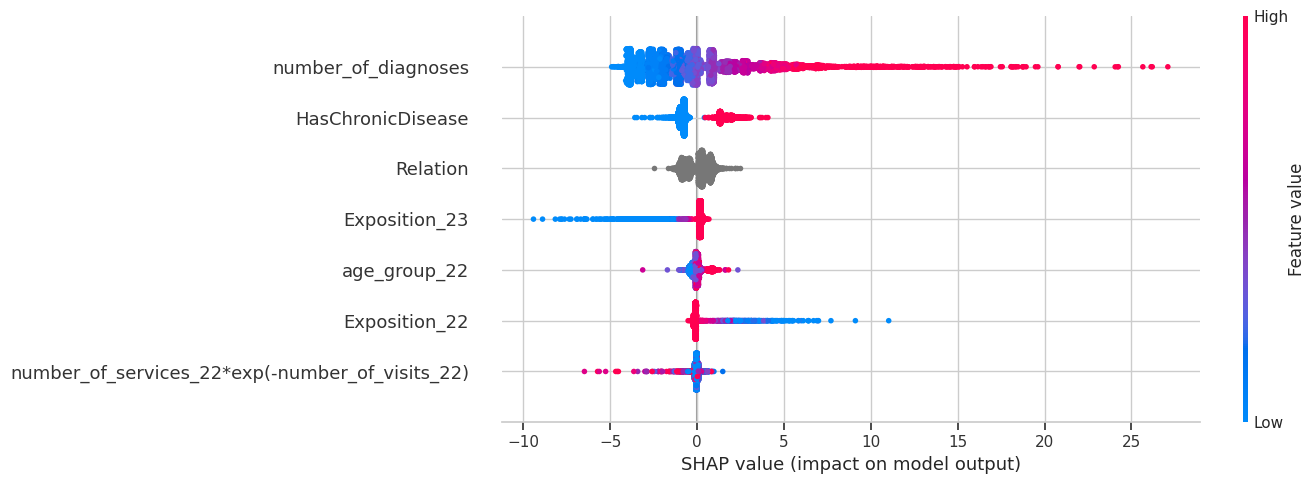

In [27]:
explainer = shap.TreeExplainer(model_cb, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_test_main)
shap.summary_plot(shap_values, X_test_main, max_display=7, plot_size=(14, 5))

### Выводы и наблюдения
- наиболее важными признаками определены `number_of_diagnoses`, `HasChronicDisease`, `Relation`, `Exposition`, `age_group`, `gender`

## Прогноз для отложенных данных

In [28]:
full_data = pd.concat([data, holdout_data], ignore_index=True)
full_data['number_of_diagnoses'] = full_data['Diagnoses'].apply(lambda x: 0 if pd.isnull(x) else len(x.split(';')))
full_data = client_age_counting(dataset=full_data,
                                birth_date='DoB',
                                fixed_dates=['2022-12-31', '2023-12-31'],
                                new_column_names=['client_age_22', 'client_age_23'])
ids = ['Insured_PIN']
target = ['number_of_visits_23']
cat_features = full_data.select_dtypes(include=['object']).drop('Diagnoses', axis=1).columns.to_list()
potential_num_features = full_data.select_dtypes(include=['number']).columns
binary_num_features = [col for col in potential_num_features if full_data[col].nunique() == 2]
num_features = list(set(potential_num_features) - set(binary_num_features) - set(ids) - set(target))
full_data.fillna({'client_age_23': full_data['client_age_23'].median(),
                  'client_age_22': full_data['client_age_22'].median()}, inplace=True)
full_data['client_age_23'] = full_data['client_age_23'].astype(int)
full_data['client_age_22'] = full_data['client_age_22'].astype(int)
ext_num_data, ext_cat_data = feature_engineering(input_data=full_data,
                                                 num_features=num_features,
                                                 target=target,
                                                 test_size=None,
                                                 input_columns=['client_age_22', 'client_age_23'],
                                                 output_columns=['age_group_22', 'age_group_23'],
                                                 transformations=["log", "exp-", "sqrt"],
                                                 data_train=full_data.loc[data.index],
                                                 data_holdout=full_data.iloc[-len(holdout_data):])
full_df = full_data.merge(ext_num_data, left_index=True, right_index=True).merge(ext_cat_data, left_index=True, right_index=True)
ext_num_features = ext_num_data.columns.to_list()
ext_cat_features = ext_cat_data.columns.to_list()
num_features_clean = num_features.copy()
cat_features_clean = cat_features.copy()
ext_cat_features_clean = ext_cat_features.copy()
num_features_clean.remove('number_of_services_22')  # коррелирует с целевым признаком
num_features_clean.remove('number_of_visits_22')  # коррелирует с целевым признаком
num_features_clean.remove('client_age_23')  # коррелирует с признаком возрастной группы
num_features_clean.remove('client_age_22')  # коррелирует с признаком возрастной группы
ext_cat_features_clean.remove('age_group_23')  # коррелирует с признаком возрастной группы
cat_features_clean.remove('Insured_Network')  # представлен только один класс
cat_features_clean.remove('Nationality')  # представлен только один класс
X_train_main, X_test_main, y_train = data_preparing(input_data=full_df,
                                                    test_size=None,
                                                    target=target,
                                                    cat_features=None,
                                                    num_features=num_features_clean+ext_num_features,
                                                    remain_features=binary_num_features+cat_features_clean+ext_cat_features_clean,
                                                    data_train=full_df.loc[data.index],
                                                    data_holdout=full_df.iloc[-len(holdout_data):])

/home/denis/Documents/main_venv/test_mains_lab/.env_lab/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denis/Documents/main_venv/test_mains_lab/.env_lab/lib/python3.10/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


Новые категориальные признаки:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   age_group_22  60000 non-null  int64
 1   age_group_23  60000 non-null  int64
dtypes: int64(2)
memory usage: 937.6 KB
Новые числовые признаки:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   number_of_visits_22*exp(-client_age_23)          60000 non-null  float64
 1   number_of_services_22*number_of_visits_22        60000 non-null  float64
 2   sqrt(client_age_23)*sqrt(number_of_visits_22)    60000 non-null  float64
 3   number_of_visits_22*exp(-number_of_visits_22)    60000 non-null  float64
 4   number_of_diagnoses*number_of_visits_22          60

In [29]:
train_pool = Pool(data=X_train_main,
                  label=y_train,
                  cat_features=cat_features_clean+ext_cat_features_clean)
holdout_pool = Pool(data=X_test_main,
                    label=None,
                    cat_features=cat_features_clean+ext_cat_features_clean)
model_cb.fit(train_pool)
holdout_pred = model_cb.predict(holdout_pool)
predictions_rounded = np.round(holdout_pred).astype(int)
holdout_data = holdout_data.assign(predictions=predictions_rounded)
holdout_data[['Insured_PIN', 'predictions']].to_csv('predictions.csv', index=False)
print("Файл predictions.csv успешно сохранен.")

Файл predictions.csv успешно сохранен.


## Отчёт по исследованию

**Загрузка данных и ознакомление с ними**

Выполнено
- данные загружены и изучены;
- в них выявлены пропуски, типы данных;
- намечен ход дальнейшей обработки

**Первичная обработка данных**

Выполнено
- добавлен признак, в котором посчитано количество диагнозов у клиента;
- добавлены признаки с возрастом клиента на конец 2022 и 2023 годов

**Исследовательский анализ данных**

Выполнено
- изучено поведение клиентов;
- изучены численные и категориальные признаки;
- проверены связи признаков с целевой переменной;
- исследованы корреляции между признаками

**Создание новых признаков (при необходимости)**

Выполнено
- добавлены категориальные признаки - возрастная группа;
- при помощи библиотеки autofeat добавлены числовые признаки

**Отбор финального набора обучающих признаков**

Выполнено
- произведён отбор финального набора признаков

**Подготовка данных для обучения**

Выполнено
- данные разделены на обучающую и тестовую выборки;
- произведено кодирование категориальных признаков;
- числовые признаки масштабированы

**Выбор и обучение моделей**

Выполнено
<br>Обучены и оценены модели:
- `linear regression` на базовых признаках без подбора гиперпараметров - в качестве baseline;
- `linear regression` на базовых признаках с подбором гиперпараметров `GridSearch`;
- `linear regression` на расширенных признаках с подбором гиперпараметров `GridSearch`;
- `Random Forest Regressor` на расширенных признаках с подбором гиперпараметров `GridSearch`;
- `CatBoost Regressor` на расширенных признаках с подбором гиперпараметров `GridSearch`

**Оценка качества предсказания лучшей модели на тестовой выборке**

Выполнено
- проверка на тестовой выборке показала адекватность обучения модели

**Анализ важности признаков лучшей модели**

Выполнено
- наиболее важными признаками определены `number_of_diagnoses`, `HasChronicDisease`, `Relation`, `Exposition`, `age_group`, `gender`

**Прогноз для отложенных данных**

Выполнено
- модель обучена на полном датасете;
- сделан прогноз для выборки `holdout`;
- прогноз сохранён в файл `predictions.csv`